In [22]:
#!/usr/bin/env python
# coding: utf-8

'''
sample command: python T4_BT19_ae.py -k 0 -c 0 -r 1 --data_dir /home/ruihan/data
Individual training for BioTac data (full/partial data)
if -r=1, train with full data
if -r=2, train with half data
loss = classification loss + recon loss 
'''

# Import
import os,sys
import pickle
import argparse
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from vrae.vrae import VRAEC
from preprocess_data import get_TrainValTestLoader, get_TrainValTestDataset, get_TrainValTestData
from vrae.visual import plot_grad_flow

# # Parse argument
# parser = argparse.ArgumentParser()
# parser.add_argument("-i", "--rep", type=int, default=0, help='index of running repetition')
# parser.add_argument('--data_dir', type=str, default='data', help="DIR set in 'gh_download.sh' to store compiled_data")
# parser.add_argument("-k", "--kfold", type=int, default=0, help="kfold_number for loading data")
# parser.add_argument("-r", "--reduction", type=int, default=1, help="data reduction ratio for partial training")
# parser.add_argument("-c", "--cuda", default=0, help="index of cuda gpu to use")
# args = parser.parse_args()

# dummy class to replace argparser, if running jupyter notebook
class Args:
    reduction = 0
    data_dir = 'data'
    kfold = 0
    cuda = '0'
    reduction = 1

args=Args()

# Set hyper params
args_data_dir = args.data_dir
kfold_number = args.kfold
data_reduction_ratio = args.reduction
shuffle = True # set to False for partial training
num_class = 20
sequence_length = 400
number_of_features = 19

hidden_size = 90
hidden_layer_depth = 1
latent_length = 40
batch_size = 32
learning_rate = 0.001 # 0.0005
n_epochs = 100
dropout_rate = 0.2
cuda = True # options: True, False
header = None

# loss weightage
w_r = 0.01
w_c = 1

np.random.seed(1)
torch.manual_seed(1)

# Load data
data_dir = os.path.join(args_data_dir, "compiled_data/")
logDir = 'models_and_stats/'
if_plot = False

# RNN block
block = "phased_LSTM" # LSTM, GRU, phased_LSTM

# model_name = 'BT19_ae_{}_wrI_{}_wC_{}_{}'.format(data_reduction_ratio, w_r, w_c, str(kfold_number))
model_name = "model_"+block+"_B"


if torch.cuda.is_available():
    device = torch.device("cuda:{}".format(args.cuda))
else:
    device = torch.device('cpu')

if args.reduction != 1:
    print("load {} kfold number, reduce data to {} folds, put to device: {}".format(args.kfold, args.reduction, device))
else:
    print("load {} kfold number, train with full data, put to devide: {}".format(args.kfold, device))

prefix = ""
dataset_dir = os.path.join(args_data_dir, "c20/") # TODO
train_set, val_set, test_set = get_TrainValTestDataset(dataset_dir, k=0, prefix=prefix, seq_len=sequence_length)
train_loader, val_loader, test_loader = get_TrainValTestLoader(dataset_dir, k=0, batch_size=batch_size,shuffle=shuffle, prefix=prefix,seq_len=sequence_length)
X_train, X_val, X_test, Y_train, Y_val, Y_test = get_TrainValTestData(dataset_dir, k=0, prefix=prefix,seq_len=sequence_length)
# Initialize models
model = VRAEC(num_class=num_class,
            block=block,
            sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            cuda = cuda,
            model_name=model_name,
            header=header,
            device = device)
model.to(device)

# Initialize training settings
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
cl_loss_fn = nn.NLLLoss()
recon_loss_fn = nn.MSELoss()

# model.load_state_dict(torch.load('models_and_stats/model_phased_LSTMlstm_B.pt', map_location='cpu'))
saved_dicts = torch.load('models_and_stats/models_contain_nan_grad/model_phased_LSTM_B33.pt', map_location='cpu')
model.load_state_dict(saved_dicts['model_state_dict'])
optimizer.load_state_dict(saved_dicts['optimizer_state_dict'])

training_start=datetime.now()
# create empty lists to fill stats later
epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
epoch_val_acc = []
max_val_acc = 0

if block == "phased_LSTM":
    times = torch.ones(batch_size, sequence_length)

load 0 kfold number, train with full data, put to devide: cpu
chop org data of length 400 into 1 segments, each of which is has length 400
chop org data of length 400 into 1 segments, each of which is has length 400
chop org data of length 400 into 1 segments, each of which is has length 400


In [23]:
for epoch in range(n_epochs):
    if epoch > 0:
        break
    # TRAIN
    model.train()
    correct = 0
    train_loss = 0
    train_num = 0
    for i, (XB,  y) in enumerate(train_loader):
        if i > 0:
            break
        if model.header == 'CNN':
            x = XI
        else:
            x = XB
        x, y = x.to(device), y.long().to(device)
        if x.size()[0] != batch_size:
            break
        
        # reduce data by data_reduction_ratio times
        if i % data_reduction_ratio == 0:
            train_num += x.size(0)
            optimizer.zero_grad()
            if block == "phased_LSTM":
                x_decoded, latent, output = model(x, times)
            else:
                x_decoded, latent, output = model(x)

            # assert not torch.isnan(y).any(), "batch_num="+str(i)
            # print((output == 0).nonzero().size(0)==0)

            assert (output == 0).nonzero().size(0)==0, 'output contain zero, batch_num'+str(i)+' indices:'+str((output == 0).nonzero())
            
            cl_loss = cl_loss_fn(output, y)
            recon_loss = recon_loss_fn(x_decoded, x)
            loss = w_c*cl_loss + w_r *recon_loss
            
            # compute classification acc
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
            # accumulator
            train_loss += loss.item()
            start_bp = datetime.now()
            print('cl_loss:', cl_loss, 'recon_loss:', recon_loss)
            loss.backward()
            figname = logDir + model_name + "grad_flow_plot_epoch" +str(epoch)+".png"
            if i == 0: # and epoch%50 == 0:
#                 for n, p in model.named_parameters():
#                     if p.requires_grad:
#                         print(n,p.grad)
#                 print("grad flow for epoch {}".format(epoch))
#                 plot_grad_flow(model.named_parameters(), figname, if_plot=False)
                k = model.encoder.k_out
                tau = model.encoder.model.phased_cell.tau
                phase = model.encoder.model.phased_cell.phase
                print('k:', k)
                print('tau:', tau)
                print('phase:', phase)
            optimizer.step()
            # print('1 batch bp time:', datetime.now()-start_bp)

    # fill stats
    train_accuracy = correct / train_num 
    train_loss /= train_num
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accuracy) 
    
    # VALIDATION
    model.eval()
    correct = 0
    val_loss = 0
    val_num = 0
    for i, (XB, y) in enumerate(val_loader):
        if model.header == 'CNN':
            x = XI
        else:
            x = XB
        x, y = x.to(device), y.long().to(device)
        if x.size()[0] != batch_size:
            break
        val_num += x.size(0)
        if block == "phased_LSTM":
            x_decoded, latent, output = model(x, times)
        else:
            x_decoded, latent, output = model(x)

        # construct loss function
        cl_loss = cl_loss_fn(output, y)
        recon_loss = recon_loss_fn(x_decoded, x)
        loss = w_c*cl_loss + w_r *recon_loss
        
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val_loss += loss.item()
    
    # fill stats
    val_accuracy = correct / val_num
    val_loss /= val_num
    epoch_val_loss.append(val_loss)  # only save the last batch
    epoch_val_acc.append(val_accuracy)
    
    # if epoch < 20 or epoch%200 == 0:
    print("train_num {}, val_num {}".format(train_num, val_num))
    print('Epoch: {} Loss: train {:.3f}, valid {:.3f}. Accuracy: train: {:.3f}, valid {:.3f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
    
    

cl_loss: tensor(nan, grad_fn=<NllLossBackward>) recon_loss: tensor(nan, grad_fn=<MseLossBackward>)
k: tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., n

# B32

In [21]:
for n, p in model.named_parameters():
    if p.requires_grad:
        print(n, '\n', p.grad, '\n', p.data)

encoder.fc.weight 
 tensor([[ 0.0476, -0.0020,  0.0085,  ..., -0.0071,  0.0072,  0.0087],
        [-0.0559, -0.0111, -0.0030,  ..., -0.0050, -0.0098, -0.0135],
        [ 0.1894,  0.0213,  0.0165,  ...,  0.0282,  0.0224,  0.0381],
        ...,
        [-0.0744, -0.0036, -0.0090,  ..., -0.0238, -0.0055, -0.0157],
        [-0.0915, -0.0070, -0.0116,  ...,  0.0034, -0.0177, -0.0224],
        [ 0.1446,  0.0138,  0.0299,  ...,  0.0080,  0.0271,  0.0369]]) 
 tensor([[ 0.0962, -0.1339, -0.0391,  ...,  0.0079, -0.0035,  0.1963],
        [ 0.0472, -0.1132, -0.1328,  ..., -0.1675,  0.1865, -0.0610],
        [ 0.0998, -0.0946,  0.2460,  ...,  0.1904,  0.1961, -0.0175],
        ...,
        [-0.0637,  0.1104,  0.0194,  ...,  0.2182, -0.1952, -0.0084],
        [-0.1803, -0.0063, -0.0896,  ...,  0.2106, -0.0826, -0.1429],
        [ 0.0562, -0.0702, -0.2841,  ..., -0.0558, -0.0312,  0.0923]])
encoder.fc.bias 
 tensor([ 0.0039, -0.0025,  0.0049,  0.0014, -0.0234, -0.0361, -0.0280,  0.0021,
        -0.0

In [10]:
model.latent

tensor([[-1.2298,  0.9993,  1.1570,  ...,  0.5158,  1.2001,  2.0645],
        [-0.7551, -0.0446,  0.3882,  ..., -0.5571,  0.4411,  1.6011],
        [ 0.8026,  0.5022, -1.3479,  ...,  0.9216, -0.4514, -1.2693],
        ...,
        [-0.8640,  0.2775,  0.8303,  ...,  2.0807,  0.2537,  0.0259],
        [-1.5042,  0.7906,  0.2099,  ..., -0.9292,  0.4017,  1.6255],
        [ 0.3486,  0.3889, -0.6923,  ...,  1.2951, -0.4356, -1.1198]],
       grad_fn=<AddmmBackward>)

In [45]:
a = torch.Tensor([[0,0,0],[0.5,0,0],[0,0,0]])
a = a  # + 1e-5
b = torch.LongTensor([1,0,1])
cl_loss_fn = torch.nn.NLLLoss()
cl_loss = cl_loss_fn(a,b)
cl_loss

tensor(-0.1667)

In [46]:
a

tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

In [47]:
a[a==0] += 1e-5
a

tensor([[1.0000e-05, 1.0000e-05, 1.0000e-05],
        [5.0000e-01, 1.0000e-05, 1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05]])

In [11]:
model.cell_output

tensor([[-8.9112e-02,  1.2708e-01, -9.4901e-02,  ..., -3.1674e-01,
          2.2952e-02,  1.9503e-01],
        [-1.7971e-01,  6.1885e-01, -1.5249e-01,  ..., -1.0224e-01,
          2.4602e-03,  1.7789e-01],
        [ 2.2590e-02, -1.6115e-01,  1.9003e-01,  ..., -1.0203e-02,
          3.5609e-03,  1.4919e-03],
        ...,
        [ 1.6272e-01,  6.4871e-01,  1.9312e-01,  ...,  7.9410e-03,
          5.8570e-02,  2.8513e-02],
        [-1.7712e-01,  6.4660e-01, -1.8619e-01,  ...,  7.6034e-01,
          1.6913e-03,  2.0129e-01],
        [ 4.5560e-02, -2.7322e-01,  1.9220e-01,  ..., -6.0587e-04,
          3.1728e-03,  1.0741e-03]], grad_fn=<SliceBackward>)

In [12]:
model.encoder.model.phased_cell.c0

tensor([[[-1.0938e-01,  1.6640e-01, -1.1733e-01,  ..., -3.3476e-01,
           2.5190e-02,  2.9042e-01],
         [-2.3589e-01,  8.0084e-01, -1.9713e-01,  ..., -9.9090e-02,
           2.4997e-03,  2.3425e-01],
         [ 2.3158e-01, -1.7619e-01,  2.4627e-01,  ..., -1.0205e-02,
           7.8403e-02,  2.7764e-01],
         ...,
         [ 2.1043e-01,  8.2889e-01,  2.5290e-01,  ...,  8.4661e-03,
           7.6851e-02,  2.2670e-01],
         [-2.3196e-01,  8.4477e-01, -2.4314e-01,  ...,  9.9703e-01,
           1.7901e-03,  2.5981e-01],
         [ 2.3226e-01, -3.0311e-01,  2.5084e-01,  ..., -6.0587e-04,
           7.8402e-02,  2.3603e-01]]], grad_fn=<AddBackward0>)

# B33

In [24]:
for n, p in model.named_parameters():
    if p.requires_grad:
        print(n, '\n', p.grad, '\n', p.data)

encoder.fc.weight 
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]]) 
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
encoder.fc.bias 
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [35]:
a = torch.Tensor([5.0])
b = torch.tensor([2.0], requires_grad=True)
c = torch.fmod(a, b)
c.backward()

RuntimeError: the derivative for 'fmod: other' is not implemented

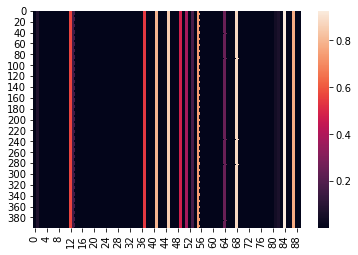

In [53]:
# B30 before grad vanishing
k = k.squeeze() # [400, 32, 90]
k = k.detach().numpy()
plt = sns.heatmap(k[:,0,:])

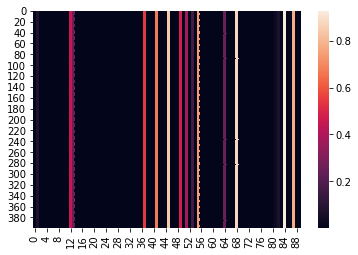

In [48]:
# B32 before grad vanishing
k = k.squeeze() # [400, 32, 90]
k = k.detach().numpy()
plt = sns.heatmap(k[:,0,:])

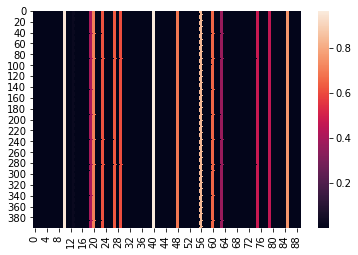

In [37]:
# B33 acc 0.8+
# k = k.squeeze() # [400, 32, 90]
# k = k.detach().numpy()
plt = sns.heatmap(k[:,0,:])

In [ ]:
# # choose model
#     # if max_val_acc <= val_accuracy:
#     #     model_dir = logDir + model_name + str(epoch) + '.pt'
#     #     print('Saving model at {} epoch to {}'.format(epoch, model_dir))
#     #     max_val_acc = val_accuracy
#     #     torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, model_dir)
#     model_dir = logDir + model_name + str(epoch) + '.pt'
#     print('Saving model at {} epoch to {}'.format(epoch, model_dir))
#     max_val_acc = val_accuracy
#     torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, model_dir)

# training_end =  datetime.now()
# training_time = training_end -training_start 
# print("training takes time {}".format(training_time))

# model.is_fitted = True
model.eval()

# TEST
correct = 0
test_num = 0
for i, (XB,  y) in enumerate(test_loader):
    if model.header == 'CNN':
        x = XI
    else:
        x = XB
    x, y = x.to(device), y.long().to(device)
    
    if x.size(0) != batch_size:
        print(" test batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break
    test_num += x.size(0)
    if block == "phased_LSTM":
        x_decoded, latent, output = model(x, times)
    else:
        x_decoded, latent, output = model(x)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
    
test_acc = correct / test_num #len(test_loader.dataset)
print('Test accuracy for', str(kfold_number), ' fold : ', test_acc)





In [ ]:
# Save stats
results_dict = {"epoch_train_loss": epoch_train_loss,
                "epoch_train_acc": epoch_train_acc,
                "epoch_val_loss": epoch_val_loss,
                "epoch_val_acc": epoch_val_acc,
                "test_acc": test_acc}

dict_name = model_name + '_stats_fold{}_{}.pkl'.format(str(kfold_number), args.rep)
pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
print("dump results dict to {}".format(dict_name))

assert n_epochs == len(epoch_train_acc), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc, label="train acc")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name +"_train_acc.png"
if if_plot:
    plt.show()